In [1]:
#!pip install torch

In [12]:
import time

In [2]:
!pip install torch_geometric

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 18.2 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=6f4f3bcc35d5fa69e9a092182cf451c368688e2ec0d0918be164568f62aadebb
  Stored in directory: /home/nbrenna4/.cache/pip/wheels/92/53/6f/2b8d654789b342509d9db30d1b420b7978da49b447a5662b05
Successfully built torch_geometric

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.nn import GCNConv, global_mean_pool

In [4]:
# Define the GNN architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, 32)  # Input has 1 channel (grayscale), output has 32 channels
        self.conv2 = GCNConv(32, 64) # Input has 32 channels, output has 64 channels
        self.fc1 = torch.nn.Linear(64, 128) # Fully connected layer
        self.fc2 = torch.nn.Linear(128, 10) # Output layer with 10 classes
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch) # Pool the node features to obtain a graph-level representation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [5]:
# Load the MNIST dataset as a graph
train_dataset = MNISTSuperpixels(root='./data', train=True, transform=None, pre_transform=None)
test_dataset = MNISTSuperpixels(root='./data', train=False, transform=None, pre_transform=None)

Extracting data/raw/MNISTSuperpixels.zip
Processing...
Done!


In [13]:
# Initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
model.train()
train_loss = []
epoch_list = []
test_loss = []
for epoch in range(100):
    tic = time.perf_counter()
    total_loss = 0
    total_nodes = 0
    for data in train_dataset:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_nodes
        total_nodes += data.num_nodes
    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Train Loss: {total_loss / total_nodes}')
        model.eval()
        correct = 0
        total = 0
        x = total_loss / total_nodes
        train_loss.append(x)
        epoch_list.append(epoch)
        for data in test_dataset:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            #print(pred, data.y)
            correct += int((pred == data.y).sum())
            total += 1
        print(f'Test Accuracy: {correct / total}') 
        y = correct / total
        test_loss.append(y)
    toc = time.perf_counter()
    print(f"Epoch run in {toc - tic:0.4f} seconds")

Epoch 0, Train Loss: 2.120118083907703
Test Accuracy: 0.2733
Epoch run in 176.5150 seconds
Epoch 1, Train Loss: 1.9278039398152709
Test Accuracy: 0.2803
Epoch run in 174.2392 seconds
Epoch 2, Train Loss: 1.8904955244271735
Test Accuracy: 0.3091
Epoch run in 174.2070 seconds
Epoch 3, Train Loss: 1.8462379550811119
Test Accuracy: 0.2927
Epoch run in 174.1788 seconds
Epoch 4, Train Loss: 1.823709907395192
Test Accuracy: 0.3078
Epoch run in 174.2534 seconds
Epoch 5, Train Loss: 1.8121111069921394
Test Accuracy: 0.3105
Epoch run in 174.2742 seconds
Epoch 6, Train Loss: 1.8024902604641633
Test Accuracy: 0.3235
Epoch run in 174.1865 seconds
Epoch 7, Train Loss: 1.7946935000203883
Test Accuracy: 0.3289
Epoch run in 174.1546 seconds
Epoch 8, Train Loss: 1.785991266366295
Test Accuracy: 0.3351
Epoch run in 174.1866 seconds
Epoch 9, Train Loss: 1.7764387689080146
Test Accuracy: 0.3345
Epoch run in 174.2745 seconds
Epoch 10, Train Loss: 1.7658081299829622
Test Accuracy: 0.3392
Epoch run in 174.189

In [ ]:
model.eval()
correct = 0
total = 0
for data in test_dataset:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
    total += 1
print(f'Test Accuracy: {correct / total}') 

In [15]:
import matplotlib.pyplot as plt

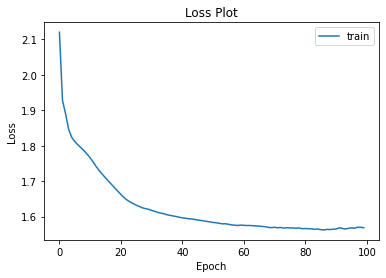

In [18]:
plt.plot(train_loss, label="train")
#plt.plot(test_loss, label="test")
plt.title("Loss Plot")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

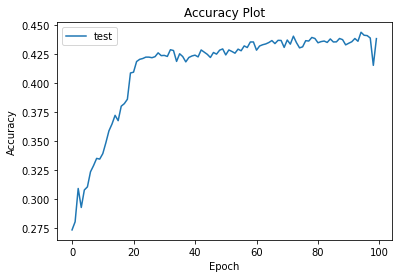

In [17]:
plt.plot(test_loss, label="test")
plt.title("Accuracy Plot")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()